<a href="https://colab.research.google.com/github/JurateKubiliene/Python_Code/blob/main/RFM_Segmentation_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Description

**Data Analysis Project:** Customer Segmentation

**Data Source:** Turing College Analytics (data for 2010-12-01 to 2011-12-01).

**Goal:** Segment customers and assign them scores depending on recency, frequency, and monetary value of their purchases.

**Segment customers into:** Best Customers, Loyal Customers, Big Spenders, Lost Customers, and other categories.

Present some insights on which customer group/customer groups the marketing team should focus on.

# Data Import, Cleaning and Exploration

# Imports

In [1]:
!pip install kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objs as go

In [4]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [5]:
from google.cloud import bigquery

In [6]:
project_id = 'tc-da-1'
client = bigquery.Client(project=project_id)

In [7]:
query = '''
SELECT *
FROM `tc-da-1.turing_data_analytics.rfm`
'''

query_job = client.query(query)

rfm_data = query_job.to_dataframe()

rfm_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536414,22139,None,56,2010-12-01 11:52:00+00:00,0.00,<NA>,United Kingdom
1,536544,22081,RIBBON REEL FLORA + FAUNA,1,2010-12-01 14:32:00+00:00,3.36,<NA>,United Kingdom
2,536544,22100,SKULLS SQUARE TISSUE BOX,1,2010-12-01 14:32:00+00:00,2.51,<NA>,United Kingdom
3,536544,22114,HOT WATER BOTTLE TEA AND SYMPATHY,3,2010-12-01 14:32:00+00:00,8.47,<NA>,United Kingdom
4,536544,22196,SMALL HEART MEASURING SPOONS,2,2010-12-01 14:32:00+00:00,1.66,<NA>,United Kingdom


# Filtering and cleaning data

In [8]:
# filtering data. Invoice dates only for 2010-12-01 to and including 2011-12-01
rfm_data['InvoiceDate'] = pd.to_datetime(rfm_data['InvoiceDate'])

rfm_df_filt = rfm_data[(rfm_data['InvoiceDate'] >= '2010-12-01') & (rfm_data['InvoiceDate'] < '2011-12-02')]
rfm_df_filt.shape[0]

519285

In [9]:
# excluding empty CustomerID values
rfm_df_fixedid = rfm_df_filt.dropna(subset=['CustomerID'])
rfm_df_fixedid.shape[0]

391394

In [10]:
# ecxluding returns
rfm_df_final_data = rfm_df_fixedid[(rfm_df_fixedid['Quantity'] > 0) & (rfm_df_fixedid['UnitPrice'] > 0)]
rfm_df_final_data.shape[0]

382720

In [11]:
warnings.filterwarnings('ignore', category=DeprecationWarning)

# adding overall_price column
overall_price = rfm_df_final_data['UnitPrice'].values * rfm_df_final_data['Quantity'].values
rfm_copy_df = rfm_df_final_data.copy()

rfm_copy_df['overall_price'] = overall_price

rfm_copy_df.shape[0]
rfm_copy_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,overall_price
135080,574301,20971,PINK BLUE FELT CRAFT TRINKET BOX,12,2011-11-03 16:15:00+00:00,1.25,12544,Spain,15.0
135081,574301,23240,SET OF 4 KNICK KNACK TINS DOILY,6,2011-11-03 16:15:00+00:00,4.15,12544,Spain,24.9
135082,574301,22086,PAPER CHAIN KIT 50'S CHRISTMAS,6,2011-11-03 16:15:00+00:00,2.95,12544,Spain,17.7
135083,574301,23514,EMBROIDERED RIBBON REEL SALLY,6,2011-11-03 16:15:00+00:00,2.08,12544,Spain,12.48
135084,574301,22960,JAM MAKING SET WITH JARS,6,2011-11-03 16:15:00+00:00,4.25,12544,Spain,25.5


# RFM Calculation

In [12]:
ref_date = pd.to_datetime('2011-12-01 23:59:59+00:00') # reference point for recency calculation

rfm_calculation = rfm_copy_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda dates: (ref_date - dates.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'overall_price': np.sum  # Monetary
})

In [13]:
rfm_calculation.columns = ['Recency', 'Frequency', 'Monetary']

rfm_calculation

,Recency,Frequency,Monetary
CustomerID,,,
12346,317,1,77183.6
12347,31,6,4085.18
12348,67,4,1797.24
12349,10,1,1757.55
12350,302,1,334.4
...,...,...,...
18280,269,1,180.6
18281,172,1,80.82
18282,118,1,100.21


In [14]:
warnings.filterwarnings('ignore', category=FutureWarning)

# set quartiles and define scores for each quartile

quartiles = rfm_calculation.quantile(q=[0.25, 0.5, 0.75])

def assign_f_and_m_score(x, quartile_values):
    if x <= quartile_values[0.25]:
        return 4
    elif x <= quartile_values[0.5]:
        return 3
    elif x <= quartile_values[0.75]:
        return 2
    else:
        return 1

def assign_r_score(x, quartile_values):
    if x <= quartile_values[0.25]:
        return 1
    elif x <= quartile_values[0.5]:
        return 2
    elif x <= quartile_values[0.75]:
        return 3
    else:
        return 4

In [15]:
# assign scores to each customer based on their quartile position (using defined function)
rfm_calculation['RecencyScore'] = rfm_calculation['Recency'].apply(assign_r_score, args=(quartiles['Recency'],))
rfm_calculation['FrequencyScore'] = rfm_calculation['Frequency'].apply(assign_f_and_m_score, args=(quartiles['Frequency'],))
rfm_calculation['MonetaryScore'] = rfm_calculation['Monetary'].apply(assign_f_and_m_score, args=(quartiles['Monetary'],))

rfm_calculation

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore
CustomerID,,,,,,
12346,317,1,77183.6,4,4,1
12347,31,6,4085.18,2,1,1
12348,67,4,1797.24,3,2,1
12349,10,1,1757.55,1,4,1
12350,302,1,334.4,4,4,3
...,...,...,...,...,...,...
18280,269,1,180.6,4,4,4
18281,172,1,80.82,4,4,4
18282,118,1,100.21,3,4,4


In [16]:
# function to assign segments based on R, F, and M scores

def assign_segments(row):
    RecencyScore = row['RecencyScore']
    FrequencyScore = row['FrequencyScore']
    MonetaryScore = row['MonetaryScore']

    if RecencyScore == 1 and FrequencyScore == 1 and MonetaryScore == 1:
        return 'Best Customers'
    elif MonetaryScore == 1 and RecencyScore in (1, 2):
        return 'Big Spenders'
    elif MonetaryScore == 1 and RecencyScore in (3, 4):
        return 'Big Spenders Slipping'
    elif RecencyScore == 4 and FrequencyScore == 4:
        return 'Lost Customers'
    elif FrequencyScore in (1, 2):
        return 'Loyal Customers'
    elif RecencyScore in (3, 4):
        return 'Other Slipping'
    elif RecencyScore == 1 and FrequencyScore == 4:
        return 'Rookies'
    elif RecencyScore in (1, 2) and FrequencyScore in (1, 2, 3):
        return 'Potential Loyalist'
    elif RecencyScore == 2 and FrequencyScore == 4:
        return 'One-time Buyers'
    else:
        return 'No Determined Segment'

In [17]:
# apply defined function to create 'Segments' column
rfm_calculation['Segments'] = rfm_calculation.apply(assign_segments, axis=1)

rfm_calculation

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,Segments
CustomerID,,,,,,,
12346,317,1,77183.6,4,4,1,Big Spenders Slipping
12347,31,6,4085.18,2,1,1,Big Spenders
12348,67,4,1797.24,3,2,1,Big Spenders Slipping
12349,10,1,1757.55,1,4,1,Big Spenders
12350,302,1,334.4,4,4,3,Lost Customers
...,...,...,...,...,...,...,...
18280,269,1,180.6,4,4,4,Lost Customers
18281,172,1,80.82,4,4,4,Lost Customers
18282,118,1,100.21,3,4,4,Other Slipping


Best Customers - most recent, most frequent, spends the most

Big Spenders - spending  the most money, but does not fit the Best Customers criteria

Big Sprenders Slipping - big spenders that did not buy recently

Loyal Customers - show the highest frequency

Lost Customers - low in all categories

One-time Buyers - bought once, short time ago

Other Slipping - other customers, who did not buy recently

Potential Loyalists - Bought more than once fairly recently

Rookies - bought for the first time recently

# KPIs

In [18]:
num_customers = rfm_copy_df['CustomerID'].nunique()
num_cust_formatted = f'{num_customers:,.0f}'
sales = rfm_copy_df['overall_price'].sum()
sales_formatted = f'${sales:,.0f}'
orders = rfm_copy_df['InvoiceNo'].nunique()
orders_formatted = f'{orders:,.0f}'

In [19]:
# functions for counting Net Promoter Score (KPI)

def promoters (Segment):
  if Segment == 'Best Customers' or Segment == 'Loyal Customers':
    return 1
  else:
    return 0

def detractors (Segment):
  if Segment == 'Lost Customers':
    return 1
  else:
    return 0

In [20]:
# count NPS, using defined function

nps_table = pd.DataFrame({'Promoters': rfm_calculation['Segments'].apply(promoters),'Detractors':rfm_calculation['Segments'].apply(detractors)})
nps = (nps_table['Promoters'].sum()/num_customers)-(nps_table['Detractors'].sum()/num_customers)
nps_perc = f'{nps:.2%}'

In [21]:
# create KPI table

kpi_table = pd.DataFrame({'Value': [num_cust_formatted, sales_formatted, orders_formatted, nps_perc]}, index=['No. of customers', 'Total sales', 'No. of orders', 'Net Promoter Score'])

kpi_table

,Value
No. of customers,"4,300"
Total sales,"$8,437,749"
No. of orders,"17,872"
Net Promoter Score,16.28%


# Visualizations

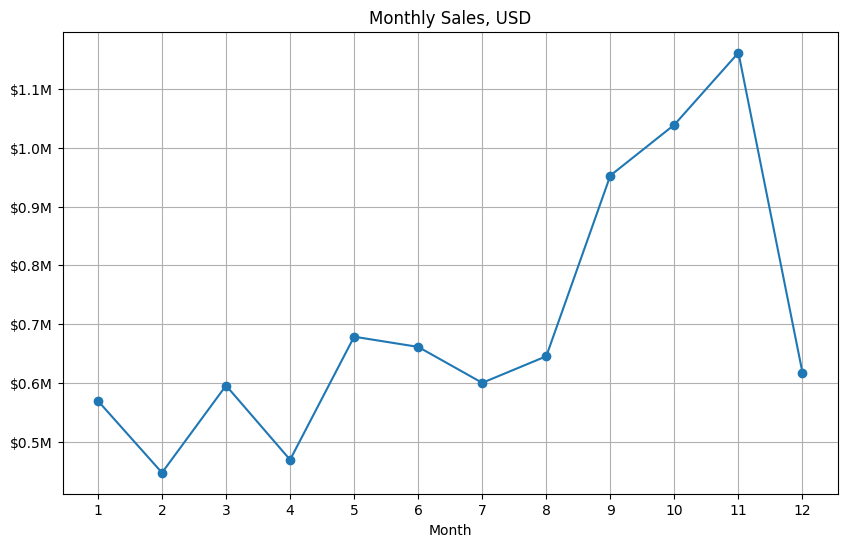

In [22]:
# plot a line chart to see how our monthly sales look like throughout time

# extract the month from the InvoiceDate
rfm_copy_df['Month'] = rfm_df_final_data['InvoiceDate'].dt.month

monthly_price = rfm_copy_df.groupby('Month')['overall_price'].sum()

plt.figure(figsize=(10, 6))
plt.plot(monthly_price.index, monthly_price.values, marker='o', linestyle='-')
plt.title('Monthly Sales, USD')
plt.xlabel('Month')

formatter = ticker.FuncFormatter(lambda x, pos: '${:,.1f}M'.format(x / 1000000))
plt.gca().yaxis.set_major_formatter(formatter)

plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


In [23]:
# build data frame for visualization charts (bar charts)
segment_counts = rfm_calculation.groupby('Segments')['Segments'].value_counts()
segment_sales = rfm_calculation.groupby('Segments')['Monetary'].sum()
sales_perc = segment_sales/sales
segment_perc = segment_counts/num_customers

rfm_chart_table = {
    'Customer Count': segment_counts.values,
    'Percent of Total Customers': segment_perc.values,
    'Percent of Total Sales': sales_perc.values,
    'Sales per Segment' : segment_sales
}

rfm_df = pd.DataFrame(rfm_chart_table)

rfm_df.reset_index(inplace=True)

rfm_df_sort = rfm_df.sort_values(by='Percent of Total Sales', ascending=False)

rfm_df_sort

,Segments,Customer Count,Percent of Total Customers,Percent of Total Sales,Sales per Segment
0,Best Customers,446,0.103721,0.47609,4017130.36
1,Big Spenders,386,0.089767,0.207031,1746878.63
4,Loyal Customers,958,0.222791,0.105272,888255.712
2,Big Spenders Slipping,243,0.056512,0.10259,865631.131
6,Other Slipping,816,0.189767,0.046321,390845.521
3,Lost Customers,704,0.163721,0.023928,201902.13
7,Potential Loyalist,336,0.078140,0.02318,195585.02
5,One-time Buyers,288,0.066977,0.01152,97199.44
8,Rookies,123,0.028605,0.004068,34321.16


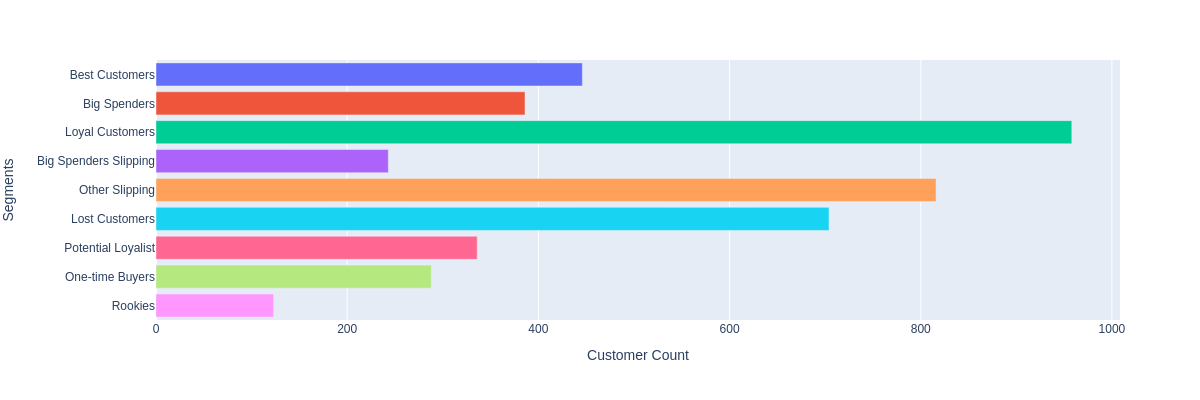

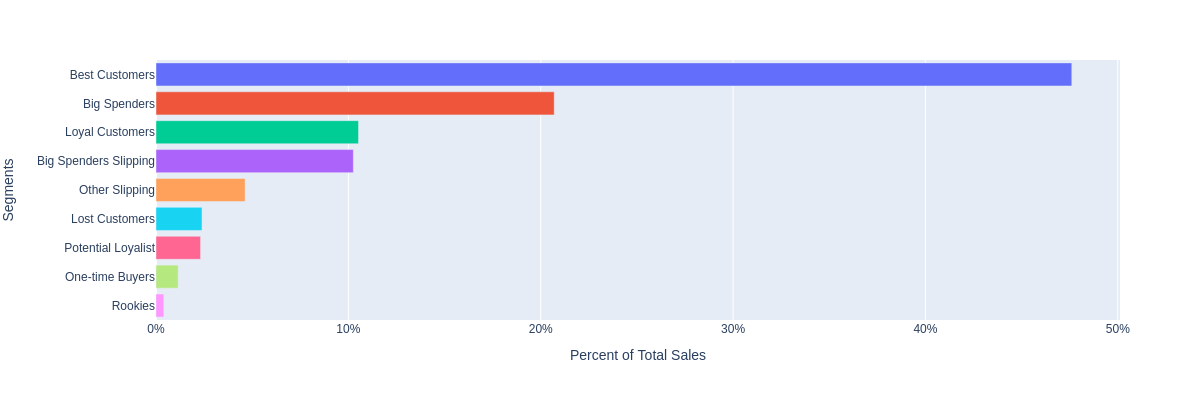

In [29]:
figure1 = px.bar(rfm_df_sort, y='Segments', x='Customer Count', orientation='h', color='Segments')
figure2 = px.bar(rfm_df_sort, y='Segments', x='Percent of Total Sales', orientation='h', color='Segments')

figure1.update_layout(showlegend=False, height=400, width=1200)
figure2.update_layout(xaxis_tickformat=',.0%', showlegend=False, height=400, width=1200)

figure1.show(renderer="png")
figure2.show(renderer="png")

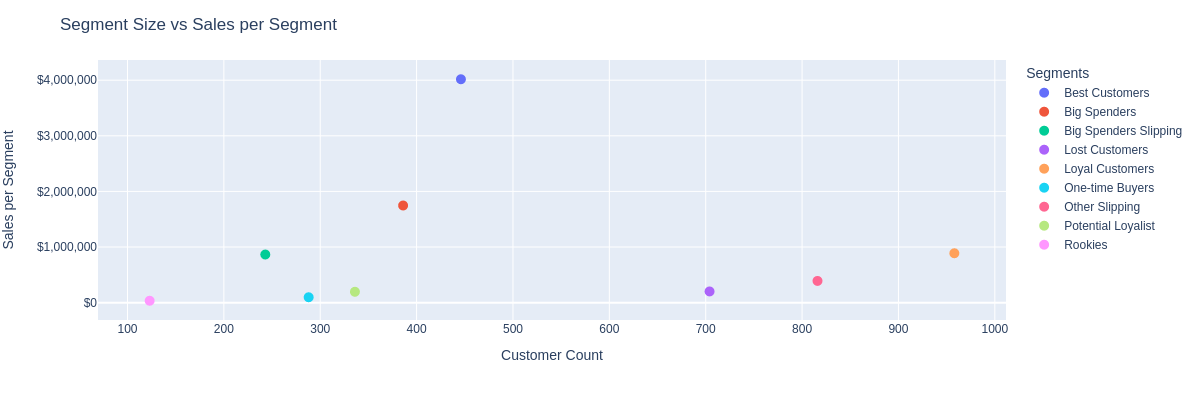

In [30]:
# create scatter plot to further ilustrate the point of the two bar charts
figure3 = px.scatter(rfm_df, x='Customer Count', y='Sales per Segment', color='Segments')

# update marker size
figure3.update_traces(marker=dict(size=10))

figure3.update_layout(
    title='Segment Size vs Sales per Segment',
    yaxis_tickformat='$,.0f',
    height=400, width=1200)

figure3.show(renderer="png")

In [26]:
# calculate average R, F and M values per segment and build a table for main scatterplot visualization

unique_segments = rfm_calculation['Segments'].unique()
avg_recency = rfm_calculation.groupby('Segments')['Recency'].mean()
avg_frequency = rfm_calculation.groupby('Segments')['Frequency'].mean()
avg_monetary = rfm_calculation.groupby('Segments')['Monetary'].mean()

data_for_scatter = {
    'Segments' : avg_recency.index,
    'Average Recency' : avg_recency.values,
    'Average Frequency' : avg_frequency.values,
    'Average Monetary' : avg_monetary.values
}

rfm_averages = pd.DataFrame(data_for_scatter)

rfm_averages

,Segments,Average Recency,Average Frequency,Average Monetary
0,Best Customers,5.932735,15.302691,9007.018744
1,Big Spenders,25.196891,7.360104,4525.592306
2,Big Spenders Slipping,107.728395,5.037037,3562.268029
3,Lost Customers,258.931818,1.000000,286.792798
4,Loyal Customers,56.611691,4.117954,927.198029
5,One-time Buyers,31.875000,1.000000,337.498056
6,Other Slipping,119.112745,1.531863,478.977354
7,Potential Loyalist,19.931548,2.000000,582.098274
8,Rookies,8.276423,1.000000,279.033821


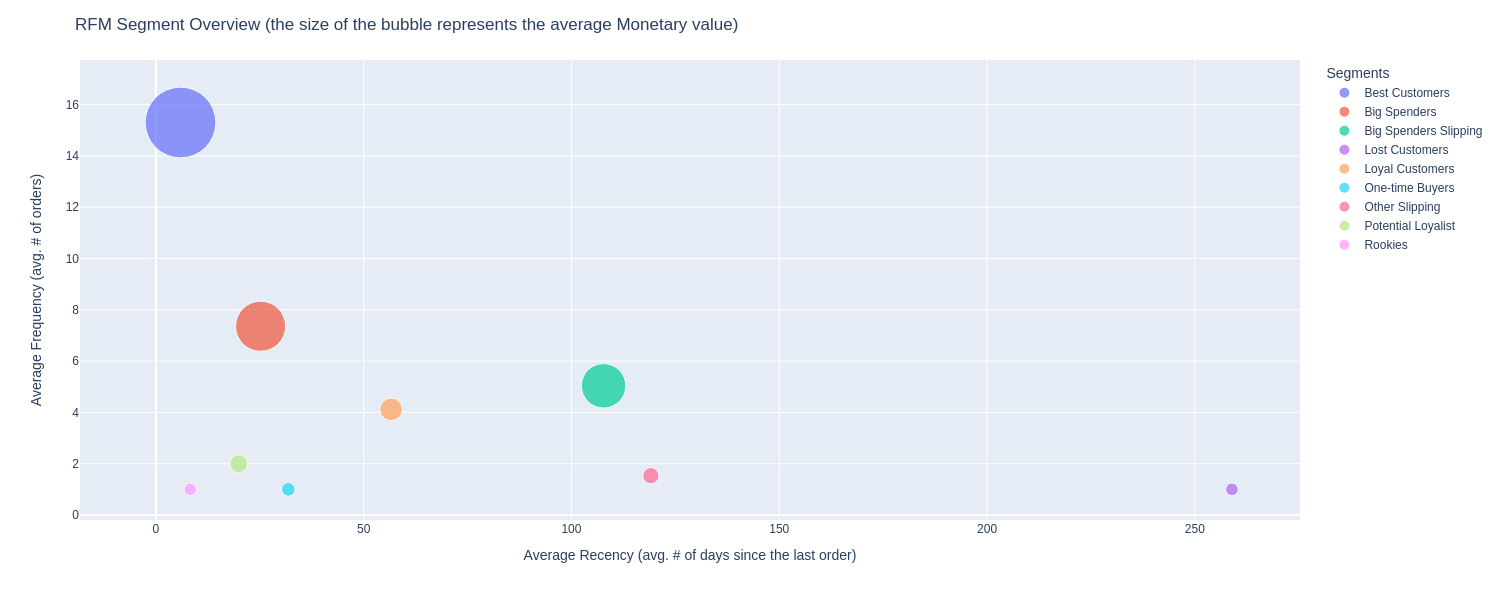

In [31]:
# create scatter plot that shows average recency, frequency and monetary for each segment

size_values = data_for_scatter['Average Monetary'].tolist()

figure4 = px.scatter(data_for_scatter, x='Average Recency', y='Average Frequency', size=size_values, color='Segments', size_max=50)

figure4.update_layout(
    title='RFM Segment Overview (the size of the bubble represents the average Monetary value)',
    yaxis_title = 'Average Frequency (avg. # of orders)',
    xaxis_title = 'Average Recency (avg. # of days since the last order)',
    height=600, width=1500)

figure4.show(renderer="png")

# Insights

Loyal Customers is the largest segment with 957 customers (22%).

2 segments (Big Spenders and Best Customers) combined make nearly 70% of overall sales revenue.

41% of total customer count is either slipping or lost. Reactivation campaigns are encouraged.

Big Spenders Slipping should be a priority to reactivate over Other Slipping or Lost Customers due to high sales value.


# Marketing Strategies
Best Customers - Reward. Introduce them to new/luxury products, loyalty programs.

Big Spenders - Offer luxury products, premium offers, subscriptions.

**Big Spenders Slipping** - Reactivate through private touch, such as individualised offers, new item suggestions based on previous orders.

Loyal Customers - Ask for reviews, engage, upsell.

Lost Customers - Reach out with a deal-offer, if no-response - ignore.

Other Slipping - Product recommendations, discounts, coupons/gift cards.

Rookies - On-boarding process, welcome emails with incentives.

Potential Loyalist - Offer loyalty program, recommend other products.

One-time Buyers - Recommendation based on the past order, ask for review, remind of ourselves.